In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import os
import numpy as np
import matplotlib.pyplot as plt
import shutil

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
from PIL import Image
from PIL import ImageFilter

## Data Preprocessing

The images came in several different folders depending on the size or color (gray, black and white, color), which will not be useful when training a model. I will create two folders with all the images joined, no matter the size or color they are. I noticed that images in the subfolders are named the same, so I need to rename them first in order to join them all in one folder. 

In [25]:
folders = ['64', '64-bw', '64-gray', '256', '256-gray', '256-bw', '128', '128-gray', '128-bw']

for a in folders:
    i=0
    for filename in os.listdir(f'Hey-Waldo/{a}/waldo'):
        dst =a + str(i) + ".jpg"
        src =f'Hey-Waldo/{a}/waldo/'+ filename 
        dst =f'Hey-Waldo/{a}/waldo/'+ dst 
          
        # rename() function will rename all the files 
        os.rename(src, dst) 
        i += 1
    

In [26]:
for a in folders:
    i=0
    for filename in os.listdir(f'Hey-Waldo/{a}/notwaldo'):
        dst =a + str(i) + ".jpg"
        src =f'Hey-Waldo/{a}/notwaldo/'+ filename 
        dst =f'Hey-Waldo/{a}/notwaldo/'+ dst 
          
        # rename() function will rename all the files 
        os.rename(src, dst) 
        i += 1

Now that the images have been put into two folders (waldo, notwaldo) it is time to make a train/validation/test split. I am going to keep 80% of files for training, 15% will be devoted to validation and the rest will be left for test.

In [36]:
# Creating Train / Val / Test folders (One time use)
root_dir = 'Hey-Waldo/waldoAll'
classes_dir = ['/waldo', '/notwaldo']

val_ratio = 0.15
test_ratio = 0.05

for cls in classes_dir:
    os.makedirs(root_dir +'/train' + cls)
    os.makedirs(root_dir +'/val' + cls)
    os.makedirs(root_dir +'/test' + cls)
    # Creating partitions of the data after shuffeling
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio + test_ratio)), 
                                                               int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        if name[-1]=='g':
            shutil.copy(name, root_dir +'/train' + cls)

    for name in val_FileNames:
        if name[-1]=='g':
            shutil.copy(name, root_dir +'/val' + cls)

    for name in test_FileNames:
        if name[-1]=='g':
            shutil.copy(name, root_dir +'/test' + cls)

Total images:  269
Training:  242
Validation:  13
Testing:  14
Total images:  20528
Training:  18475
Validation:  1026
Testing:  1027


Now let's take a look at some of our images. I will plot 8 of Waldo images and 8 without. 

In [2]:
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

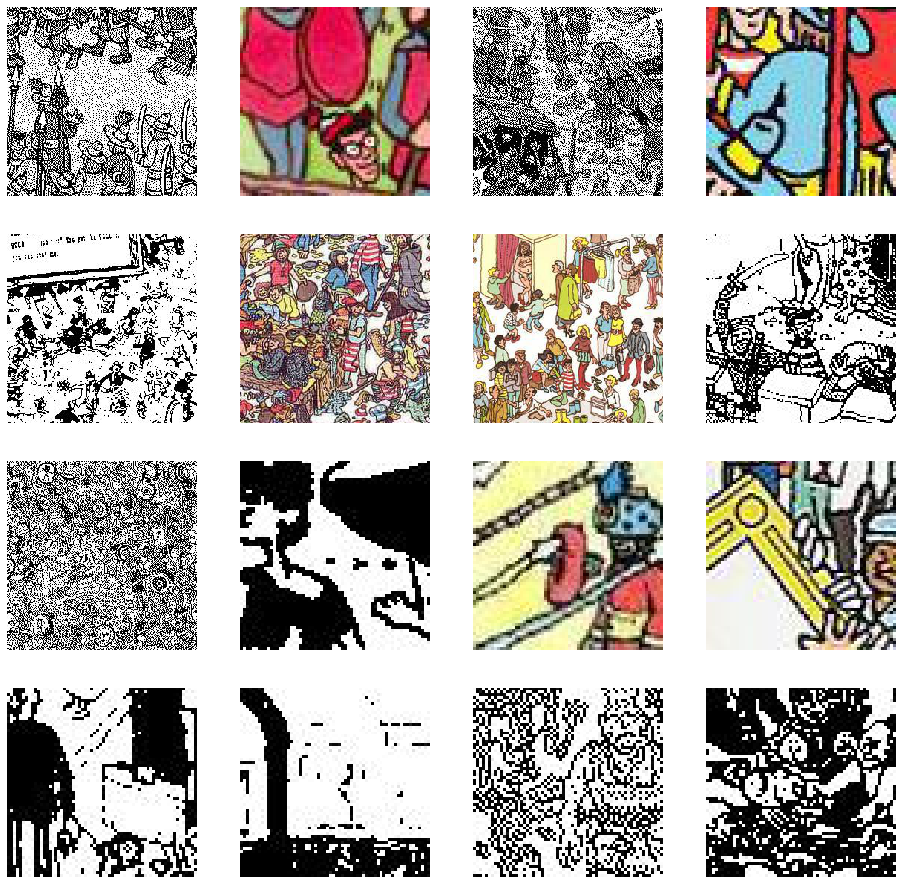

In [3]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_waldo_pix = [os.path.join('Hey-Waldo/waldoAll/train/waldo/', fname) 
                for fname in os.listdir('Hey-Waldo/waldoAll/train/waldo/')[0:8]]
next_not_waldo_pix = [os.path.join('Hey-Waldo/waldoAll/train/notwaldo/', fname) 
                for fname in os.listdir('Hey-Waldo/waldoAll/train/notwaldo/')[0:8]]

for i, img_path in enumerate(next_waldo_pix+next_not_waldo_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


As we can see above, there is a large variety of images, some are grayscale, some are color, some are balck and white. The model will have a lot to learn from. The source (Kaggle) stated that there was class imbalance. Let's check how imbalanced our data is.

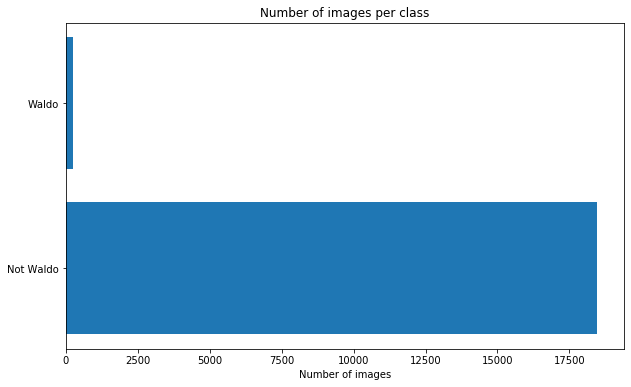

In [4]:
plt.figure(figsize = (10,6))

number = [len(os.listdir('Hey-Waldo/waldoAll/train/notwaldo/')),len(os.listdir('Hey-Waldo/waldoAll/train/waldo/'))]
classes = ['Not Waldo', 'Waldo']
 
# Create horizontal bars
plt.barh(classes, number)
 
# Create names on the y-axis
plt.yticks(classes)
plt.xlabel('Number of images')
plt.title('Number of images per class') 
# Show graphic
plt.show()

There is definitely a significant imbalance, the model built with such data would not be very accurate. We will nedd to use both upsampling and downsampling in this case. First of all, let's start with upsampling. I am going to save every image as R, B, and G, as well as augment every image to blurry and unsharp. 

In [7]:

for imagefile in os.listdir('Hey-Waldo/waldoAll/train/waldo/'):
    im=Image.open('Hey-Waldo/waldoAll/train/waldo/'+str(imagefile))             
    im=im.convert("RGB")
    r,g,b=im.split()
    r=r.convert("RGB")
    g=g.convert("RGB")
    b=b.convert("RGB")
    im_blur=im.filter(ImageFilter.GaussianBlur)
    im_unsharp=im.filter(ImageFilter.UnsharpMask)
    r.save('r_'+imagefile)
    g.save('g_'+imagefile)
    b.save('b_'+imagefile)
    im_blur.save('bl_'+imagefile)
    im_unsharp.save('un_'+imagefile)

In [11]:
print(len(os.listdir('Hey-Waldo/waldoAll/train/notwaldo/')))
print(len(os.listdir('Hey-Waldo/waldoAll/train/waldo/')))

18474
1458


As we can see, the above steps produced about a 1000 images, but this is still not even close to being a balanced dataset. The next step I am going to take is applying a random vertical and horizontal shift. This is what the resulting images will look like:

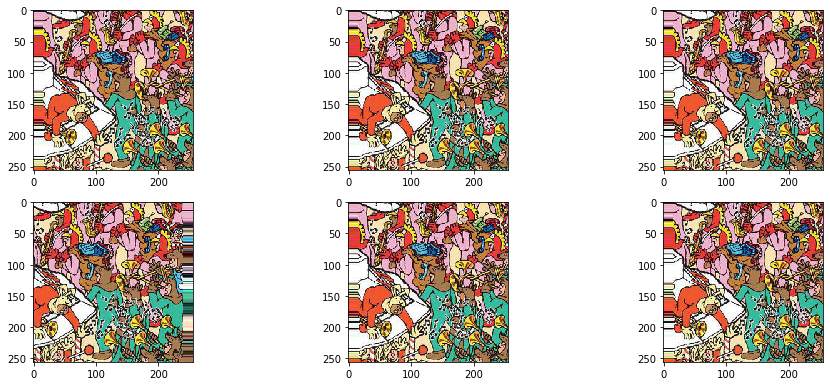

In [43]:
# horizontal shift
im=Image.open('Hey-Waldo/waldoAll/train/waldo/2562.jpg')  
datagen = ImageDataGenerator()
    #Random horizontal shift
data = img_to_array(im)
samples = expand_dims(data, 0)
datagen = ImageDataGenerator(width_shift_range=[-15,15])
it = datagen.flow(samples, batch_size=1)
plt.figure(figsize=(16,10))
for i in range(6):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image1 = batch[0].astype('uint8')
    plt.imshow(image1)
plt.show()
        

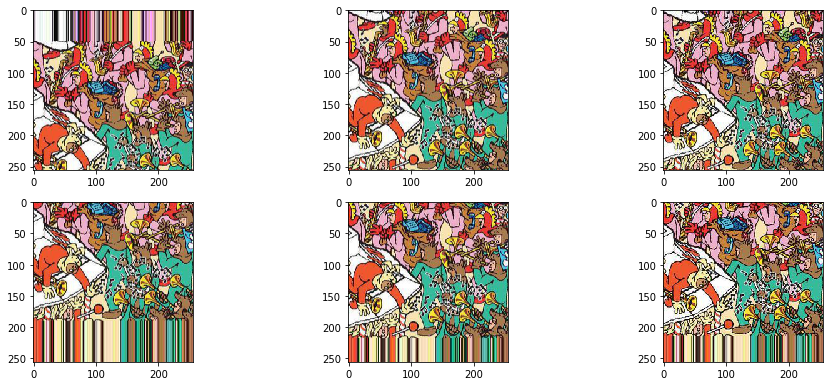

In [46]:
# vertical shift
im=Image.open('Hey-Waldo/waldoAll/train/waldo/2562.jpg') 
datagen1 = ImageDataGenerator()
data1 = img_to_array(im)
samples = expand_dims(data1, 0)
datagen1 = ImageDataGenerator(height_shift_range=0.5)
it = datagen1.flow(samples, batch_size=1)
plt.figure(figsize=(16,10))
for i in range(6):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image2 = batch[0].astype('uint8')
    plt.imshow(image2)
plt.show()

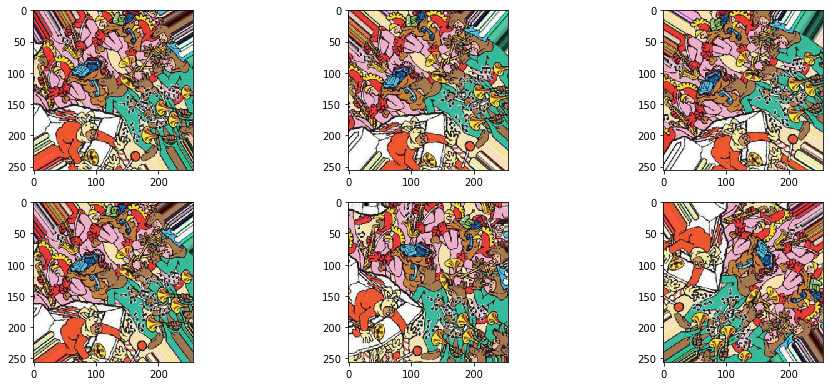

In [42]:
# random rotation
im=Image.open('Hey-Waldo/waldoAll/train/waldo/2562.jpg')
# convert to numpy array
data1 = img_to_array(im)
# expand dimension to one sample
samples = expand_dims(data1, 0)
# create image data augmentation generator
datagen1 = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen1.flow(samples, batch_size=1)
plt.figure(figsize=(16,10))
for i in range(6):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image2 = batch[0].astype('uint8')
    plt.imshow(image2)
plt.show()

In [20]:
for imagefile in os.listdir('Hey-Waldo/waldoAll/train/waldo/'):
    im=Image.open('Hey-Waldo/waldoAll/train/waldo/'+str(imagefile))  
    datagen = ImageDataGenerator()
    #Random horizontal shift
    data = img_to_array(im)
    samples = expand_dims(data, 0)
    datagen = ImageDataGenerator(width_shift_range=[-15,15])
    datagen2 = ImageDataGenerator(height_shift_range=0.5)
    it = datagen.flow(samples, batch_size=1)
    it2 = datagen2.flow(samples, batch_size=1)
    for i in range(3):
        batch = it.next()
        batch2 = it2.next()
        image1 = batch[0].astype('uint8')
        im = Image.fromarray(image1)
        im.save(str(i)+'_horiz'+imagefile)
        image2 = batch2[0].astype('uint8')
        im2 = Image.fromarray(image2)
        im2.save(str(i)+'_vertic'+imagefile)

In [54]:
print(len(os.listdir('Hey-Waldo/waldoAll/train/notwaldo/')))
print(len(os.listdir('Hey-Waldo/waldoAll/train/waldo/')))

18474
21925


In [48]:
for imagefile in os.listdir('Hey-Waldo/waldoAll/train/waldo/'):
    im=Image.open('Hey-Waldo/waldoAll/train/waldo/'+str(imagefile))  
    datagen = ImageDataGenerator(rotation_range=90)
    #Random horizontal shift
    data = img_to_array(im)
    samples = expand_dims(data, 0)
    it = datagen.flow(samples, batch_size=1)
    batch = it.next()
    image1 = batch[0].astype('uint8')
    im = Image.fromarray(image1)
    im.save('Hey-Waldo/waldoAll/train/waldo/'+'flip_'+imagefile)
     

In [55]:
print(len(os.listdir('Hey-Waldo/waldoAll/train/notwaldo/')))
print(len(os.listdir('Hey-Waldo/waldoAll/train/waldo/')))

18474
21925


In [56]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        36928     
__________

In [58]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['accuracy'])

In [59]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,
      zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'Hey-Waldo/waldoAll/train',  # This is the source directory for training images
        target_size=(128, 128),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'Hey-Waldo/waldoAll/val',  # This is the source directory for training images
        target_size=(128, 128),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 40399 images belonging to 2 classes.
Found 1039 images belonging to 2 classes.


In [62]:
print(os.listdir('Hey-Waldo/waldoAll/train'))

['notwaldo', 'waldo']


In [71]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=150,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)
      #class_weight=weight)

Epoch 1/150
8/8 [==============================] - 5s 594ms/step - loss: 0.5044 - acc: 0.7607 - val_loss: 0.2639 - val_acc: 0.9141
Epoch 2/150
8/8 [==============================] - 4s 532ms/step - loss: 0.4931 - acc: 0.7676 - val_loss: 0.1887 - val_acc: 0.9648
Epoch 3/150
8/8 [==============================] - 4s 552ms/step - loss: 0.4903 - acc: 0.7812 - val_loss: 0.3877 - val_acc: 0.8398
Epoch 4/150
8/8 [==============================] - 4s 547ms/step - loss: 0.5257 - acc: 0.7324 - val_loss: 0.3151 - val_acc: 0.8906
Epoch 5/150
8/8 [==============================] - 5s 582ms/step - loss: 0.4950 - acc: 0.7715 - val_loss: 0.3328 - val_acc: 0.8867
Epoch 6/150
8/8 [==============================] - 4s 541ms/step - loss: 0.4869 - acc: 0.7715 - val_loss: 0.2058 - val_acc: 0.9648
Epoch 7/150
8/8 [==============================] - 5s 572ms/step - loss: 0.4773 - acc: 0.7822 - val_loss: 0.2051 - val_acc: 0.9531
Epoch 8/150
8/8 [==============================] - 5s 596ms/step - loss: 0.4802 - a

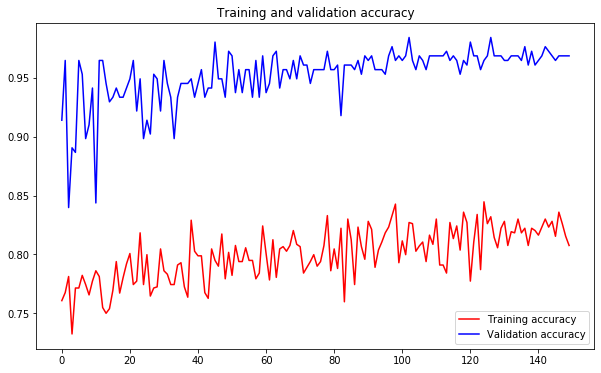

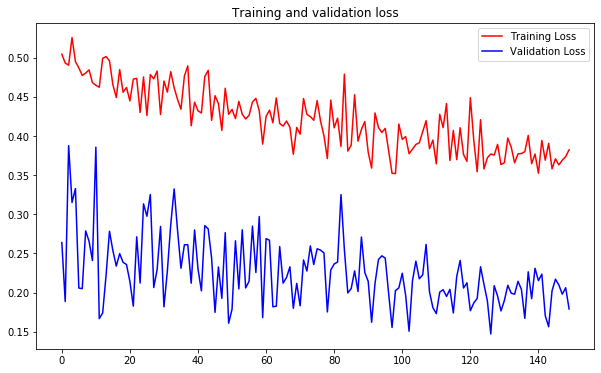

In [72]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(10,6))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [73]:
#uploaded = files.upload()

for fn in os.listdir('Hey-Waldo/waldoAll/test/waldo'):
 
  # predicting images
    path = 'Hey-Waldo/waldoAll/test/waldo/'+ fn
    img = image.load_img(path, target_size=(128, 128))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(fn)
    print(classes)

25616.jpg
[[0.]]
256-gray10.jpg
[[0.]]
128-bw19.jpg
[[0.]]
256-gray11.jpg
[[0.]]
1280.jpg
[[0.]]
12815.jpg
[[0.]]
64-bw28.jpg
[[0.]]
64-gray19.jpg
[[0.]]
64-bw4.jpg
[[0.]]
12823.jpg
[[0.]]
128-gray6.jpg
[[0.]]
64-gray21.jpg
[[0.]]
64-gray2.jpg
[[0.]]
256-gray21.jpg
[[0.]]
